## Bengio multi-char context NN
Here we implement a variant of Bengio et al. paper.

Given multiple-character input context, we predict the next char.

In the Simple NN, we directly connect a 27-neuron layer to the input one-hot vectors.

In this bengio implementation:
- We encode the chars using x-dim embeddings (rather than one-hot vector), thus more space efficient (and these embeddings will also be learned)
- We pass in multiple chars/embeddings together and simple join them. This merged embedding is then passed into the hidden layer network
- The hidden layer of the network allows the NN to have more time to find dependencies/learn connections
- The final output layer will be like the simple NN, i.e. a 27-neuron output where the output is the conditional probability distribution of the next char
- We'll have the same score function (exponential + normalize (i.e. softmax)) with the same negative log likelihood loss function

The more context we provide, the better the predictions should become.

In [521]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
g = torch.Generator().manual_seed(2147483647)

In [522]:
# Load the dataset
with open('names.txt', 'r') as f:
    names = f.read().splitlines()

print(f"Count: {len(names)}, sample: {names[:5]}...")

Count: 32033, sample: ['emma', 'olivia', 'ava', 'isabella', 'sophia']...


In [523]:
# Write the functions to convert chars to/from integer representation
vocab = sorted(list(set("".join(names))))
print(f"Vocab: {vocab}")

stoi = {c: i+1 for i,c in enumerate(vocab)}
stoi['.'] = 0
print(f"stoi length: {len(stoi)}")
itos = {i: s for s,i in stoi.items()}

def encode(s):
    return [stoi[c] for c in s.lower()]
    
def decode(ix):
    return ''.join(itos[i] for i in ix)

#Testing
test = "hello"
print(f"String: {test}")
print(f"Encoded: {encode(test)}")
print(f"Decoded: {decode(encode(test))}")

Vocab: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
stoi length: 27
String: hello
Encoded: [8, 5, 12, 12, 15]
Decoded: hello


In [524]:
#Unlike before, here we want to be able to vary the block_size
block_size = 4 #context size
embed_size = 10

#We also need to create the embedding!
#How can we squash the embedding? We'll need an embedding table! Let's use one-hot encoding to select the relevant length (more efficient + differentiable, than hash table)

context = torch.randn((len(stoi), embed_size), requires_grad=True, dtype=torch.float32)

# Prepare the data. We append start & end tokens '.', and creating sliding window of size 2 across the names.
xs, ys = [], []

# Build the dataset
for n in names:
    print(n)
    context = [0] * block_size
    chs = list(n) + ['.']
    for ch in chs:
        ix1 = stoi[ch]
        xs.append(context)
        ys.append(ix1)
        print(f'{''.join([itos[j] for j in context])} --> {itos[ix1]}')
        
        context = context[1:] + [ix1]


# Convert to tensors - better for operations
xs = torch.tensor(xs)
ys = torch.tensor(ys)

# Split into train/val/test
n = len(xs)
train_split = int(0.8 * n)
valid_split = int(0.9 * n)

X_train, Y_train = xs[:train_split], ys[:train_split]
X_valid, Y_valid = xs[train_split:valid_split], ys[train_split:valid_split]
X_test, Y_test = xs[valid_split:], ys[valid_split:]


emma
.... --> e
...e --> m
..em --> m
.emm --> a
emma --> .
olivia
.... --> o
...o --> l
..ol --> i
.oli --> v
oliv --> i
livi --> a
ivia --> .
ava
.... --> a
...a --> v
..av --> a
.ava --> .
isabella
.... --> i
...i --> s
..is --> a
.isa --> b
isab --> e
sabe --> l
abel --> l
bell --> a
ella --> .
sophia
.... --> s
...s --> o
..so --> p
.sop --> h
soph --> i
ophi --> a
phia --> .
charlotte
.... --> c
...c --> h
..ch --> a
.cha --> r
char --> l
harl --> o
arlo --> t
rlot --> t
lott --> e
otte --> .
mia
.... --> m
...m --> i
..mi --> a
.mia --> .
amelia
.... --> a
...a --> m
..am --> e
.ame --> l
amel --> i
meli --> a
elia --> .
harper
.... --> h
...h --> a
..ha --> r
.har --> p
harp --> e
arpe --> r
rper --> .
evelyn
.... --> e
...e --> v
..ev --> e
.eve --> l
evel --> y
vely --> n
elyn --> .
abigail
.... --> a
...a --> b
..ab --> i
.abi --> g
abig --> a
biga --> i
igai --> l
gail --> .
emily
.... --> e
...e --> m
..em --> i
.emi --> l
emil --> y
mily --> .
elizabeth
.... --> e
...e --

In [525]:
# We have our dataset loaded. Now we want to set-up an embedding table + block size.
#The embeddings will be learned
C = torch.randn(len(stoi), embed_size, generator=g)
C[5]

tensor([ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
        -0.9103, -0.7830])

In [526]:
#To select an embedding for a given x, we can do as follows:
F.one_hot(torch.tensor(5), num_classes=len(stoi)).float() @ C
#This should be identical to the selection above.

tensor([ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
        -0.9103, -0.7830])

In [527]:
# Now, given the inputs, we pull num=block_size embeddings from C.
# Then, we join these embeddings together and pass it through a linear layer (with a tanh activation)
# The linear layer activation then goes into a layer with len(stoi) neurons, that then computes the output probability distribution
# We can then backprop through this to predict the next token

temp = None

for x in X_train[2:3]:
    print(f"x: {x}")
    temp = x
    inputs = F.one_hot(torch.tensor(x), num_classes=len(stoi)).float()
    print(inputs.shape)
    embeddings = inputs @ C
    print(embeddings)
    print(embeddings.shape)
    #We can then change this view into a single block. Using view is efficient as we do not memcpy
    print(embeddings.view(block_size * embed_size)) #we could also do -1

#Check -> should be identical embeddings as before!
for val in temp:
    print(C[val])

x: tensor([ 0,  0,  5, 13])
torch.Size([4, 27])
tensor([[ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046],
        [ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
          0.0791,  0.9046],
        [ 0.1156,  0.8032,  0.5411, -1.1646,  0.1476, -1.0006,  0.3801,  0.4733,
         -0.9103, -0.7830],
        [-0.3111, -0.3060, -1.7495, -1.6335,  0.3876,  0.4724,  1.4830,  0.3175,
          1.0588,  2.3982]])
torch.Size([4, 10])
tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.0791,  0.9046,  1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296,
        -1.5471,  0.6049,  0.0791,  0.9046,  0.1156,  0.8032,  0.5411, -1.1646,
         0.1476, -1.0006,  0.3801,  0.4733, -0.9103, -0.7830, -0.3111, -0.3060,
        -1.7495, -1.6335,  0.3876,  0.4724,  1.4830,  0.3175,  1.0588,  2.3982])
tensor([ 1.5674, -0.2373, -0.0274, -1.1008,  0.2859, -0.0296, -1.5471,  0.6049,
         0.079

/var/folders/b9/781km4td3bx3b4cv0_m9zp680000gn/T/ipykernel_41037/2889832684.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = F.one_hot(torch.tensor(x), num_classes=len(stoi)).float()


In [528]:
#PyTorch-ifying our code
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + [self.bias if self.bias is not None else []]

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Gain & bias trained with backprop so the gaussians can evolve
        self.gamma = torch.ones(dim)
        self.beta = torch.ones(dim)

        #We maintain a running mean and variance, so that during inference we can apply the normalization
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.std(0, keepdim=True)
        else:
            xvar = self.running_var
        
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            # Update the running mean/var for inference
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [529]:
#Here we can implement some logging and hyperparameters
losses = []
lri = []
batch_size = 32
n_hidden = 200

C = torch.randn((len(stoi), embed_size), generator=g)

layers = [
    Linear(embed_size * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, len(stoi))
]

with torch.no_grad():
    # Make the layer guesses less confident to start from a lower loss
    layers[-1].weight *= 0.1

    #Apply gain to other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

#No one initializes these params by hand typically
# W1 = torch.randn((block_size*embed_size, 300), generator=g) * (5/3) / (embed_size * block_size) ** 0.5 #0.15 (Kaiming init for tanh)
# #Note: Kaiming was replaced with BatchNorm, we simply normalize the outputs.

# b1 = torch.randn(300, generator=g) * 0.01

# W2 = torch.randn((300, len(stoi)), generator=g) * 0.01 #Scaling to low is better so outputs are quite uniform and close to 0. Don't set 0 as no entropy leads to symmetry
# b2 = torch.randn(len(stoi), generator=g) * 0 #We initialize as 0 because we don't want to add random values (which leads to high initial loss)

# bngain = torch.ones((1, 300))
# bnbias = torch.ones((1,300))

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]

176697


In [530]:
# Finding the optimal learning rate
#1. Try for 10 iterations with various learning rates
#2. Find the max(just before exploding) and min (barely any change)
# Linspace-> doesn't make sense, we would want something more exponential -> take the e^linspace
# Plot the lre against loss, and identify the lowest point (for us it's -0.1). Use this as lr for first 10000 iterations
# When learning plateaus, apply learning rate decay (reduce lr by 10x) and run again for another 10000 ite
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

In [531]:
# of parameters
sum(p.nelement() for p in parameters)

176697

In [532]:
# Set params true
for p in parameters:
    p.requires_grad = True

In [533]:
# #For debugging purposes, to view the tanh saturation

# with torch.no_grad():
#     batch = torch.randint(0, len(X_train), (batch_size, ), generator=g)
#     x = X_train[batch]

#     embeddings = C[x]

#     #Retrieve the embeddings & view as block_size
#     # print(embeddings.view(batch_size, block_size * embed_size))

#     # Pass the embeddings through the LinearLayer
#     h = torch.tanh(embeddings.view(batch_size, block_size * embed_size) @ W1 + b1)

#     # Implement a batchnorm layer
#     # batchnorm1 = BatchNorm(hidden1)

#     logits = h @ W2 + b2
#     counts = logits.exp()
#     p = counts / counts.sum(dim=1, keepdim=True) #We sum across the rows (dim=1)
#     loss = -p[(torch.arange(batch_size), Y_train[batch])].log().mean()

#     with torch.no_grad():
#         plt.plot(h[0])

In [534]:
#Here we implement our training
max_steps = 100000
for i in range(max_steps):
    #Get a batch from the training set
    # batch = torch.randint(0, len(X_train), (batch_size, ), generator=g)
    # x = X_train[batch]
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) #concatenate the vectors -> later build a special Embedding layer

    for layer in layers:
        x = layer(x)

    # counts = logits.exp()
    # p = counts / counts.sum(dim=1, keepdim=True) #We sum across the rows (dim=1)
    # loss = -p[(torch.arange(batch_size), Y_train[batch])].log().mean()
    # The above 3 lines is equivalent to the cross entropy
    loss = F.cross_entropy(x, Yb)

    for p in parameters:
        p.grad = None
    
    loss.backward()

    # lr = lrs[i]
    for p in parameters:
        #Every 10 000 iterations, decrease lr by 10x (as we're in late stage of training)
        lr = 0.01 if i < 50000 else 0.001
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"Epoch: {i}/{max_steps}, loss: {loss}")
    
    # lri.append(lre[i])
    losses.append(loss.item())


Epoch: 0/100000, loss: 3.2719435691833496
Epoch: 10000/100000, loss: 2.087423086166382
Epoch: 20000/100000, loss: 2.2172532081604004
Epoch: 30000/100000, loss: 1.9648001194000244
Epoch: 40000/100000, loss: 2.2482199668884277
Epoch: 50000/100000, loss: 1.8735429048538208
Epoch: 60000/100000, loss: 1.896508812904358
Epoch: 70000/100000, loss: 2.1389853954315186
Epoch: 80000/100000, loss: 2.324604034423828
Epoch: 90000/100000, loss: 2.214503049850464


In [535]:
#Visualize histoagrams of tanh values (ensure minimal saturation)
#TODO

#Visualize histogram of the gradients (ensure they are roughly equal across layers (i.e. no exploding/vanishing gradientS))

In [536]:
# plt.figure(figsize=(20,10))
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

# #If it's not saturated, we should see mostly black. 

In [537]:
# print(h.shape) # 32, 300

# #We show the tanh function 
# plt.hist(h.view(-1).tolist(), 50); #View it as a flat vector, then plot a histogram of 50 bins

# # We see that the tanh function is heavily saturated on the ends.
# # This is very bad because in the backprop, the self.grad = (1 - t ** 2)*out.grad. tanh ranges from -1 to 1. 
# # Thus, our grad gets zeroed out at the ends & no more gradient propagates. 
# # This means the neuron stops learning (because hpreact.data += -lr*hpreact.grad), but hpreact.grad=(1 - t**2) * h.grad = 0

# # Visually, this makes sense. -1 & 1 occurs at the tailends of the wavy tanh function, which is where the gradient approachsa

In [538]:
# #The above diagram indicates heavily satured tanh function. This is bad. This means the neurons are dead or always activate (thus don't learn)

# #We can check the pre-activation to see the values
# hpreact = hpreact*2
# plt.hist(hpreact.view(-1).tolist(), 50); #View it as a flat vector, then plot a histogram of 50 bins

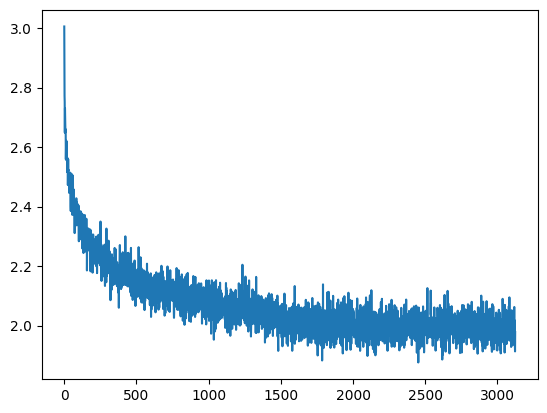

In [539]:
import matplotlib.pyplot as plt

#Batch gradients are unstable, so we normalized for less thick loss plot
normalized = []

temp = 0
for i, loss in enumerate(losses):
    if i % batch_size == 0 and i != 0:
        normalized.append(temp/batch_size)
        temp=0
    
    temp += loss

plt.plot(normalized)
# We see that 10^-1 was the lowest, so we set our lr to -0.1

In [540]:
print(loss)

1.9694187641143799


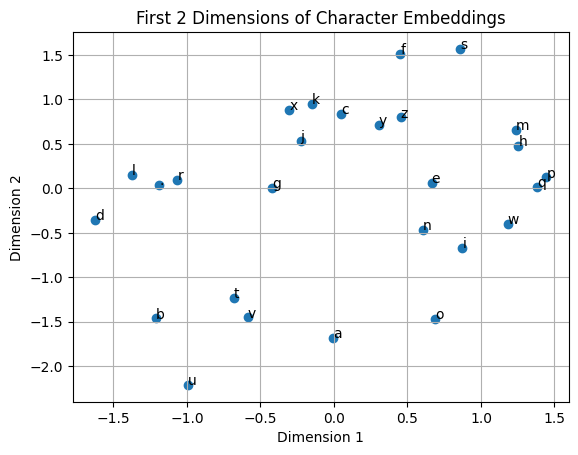

In [541]:
# Plot the embeddings

with torch.no_grad():
    # Take first 2 dimensions of embeddings
    embeddings_2d = C[:, :2]  # Get first 2 dimensions
    x = embeddings_2d[:, 0].numpy()  # First dimension 
    y = embeddings_2d[:, 1].numpy()  # Second dimension
    
    # Plot each point
    plt.scatter(x, y)
    
    # Add character labels for each point
    for i in range(len(stoi)):
        plt.annotate(itos[i], (x[i], y[i]))
    
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2') 
    plt.title('First 2 Dimensions of Character Embeddings')
    plt.grid(True)
    plt.show()

#Ideally, we'll want to see that the vowels are clustered together. Seems like it, so great!

In [542]:
# Check validation loss
with torch.no_grad():
    embeddings = C[X_train]
    h = torch.tanh(embeddings.view(len(X_train), block_size * embed_size) @ W1 + b1)
    logits = h @ W2 + b2
    training_loss = F.cross_entropy(logits, Y_train)

    embeddings = C[X_valid]
    hpreact = embeddings.view(len(X_train[ix]), block_size * embed_size) @ W1 + b1 
    #We'd like the backprop to adjust the gaussian i.e. learn this. So we add in a bngain and bnbias
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    validation_loss = F.cross_entropy(logits, Y_valid)

print(training_loss)
print(validation_loss)

# tensor(2.5976)
# tensor(2.8079)
#Pretty high loss, but and we see validation > training, thus we are underfitting the data and we need a larger model to fit the data better

RuntimeError: shape '[32, 40]' is invalid for input of size 912600

In [317]:
# Inference

result = []
curr_index = 0

context = [0]*block_size
with torch.no_grad():
    while True:
        embeddings = C[context]

        h = torch.tanh(embeddings.view(-1, block_size * embed_size) @ W1 + b1)
        print(f"Hidden layer shape: {h.shape}")

        logits = h @ W2 + b2
        print(f"Logits shape: {logits.shape}")
        counts = logits.exp()
        p = counts / counts.sum(dim=1, keepdim=True) #We sum across the rows (dim=1)
        print(p.shape) #1, 27 -> Makes sense, batch_size = 1, output is 27 neurons
        
        sample = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

        context = context[1:] + [sample]
        print(context)
        result.append(itos[sample])

        if sample == 0:
            print("".join(result))
            break

Hidden layer shape: torch.Size([1, 300])
Logits shape: torch.Size([1, 27])
torch.Size([1, 27])
[0, 0, 0, 10]
Hidden layer shape: torch.Size([1, 300])
Logits shape: torch.Size([1, 27])
torch.Size([1, 27])
[0, 0, 10, 9]
Hidden layer shape: torch.Size([1, 300])
Logits shape: torch.Size([1, 27])
torch.Size([1, 27])
[0, 10, 9, 3]
Hidden layer shape: torch.Size([1, 300])
Logits shape: torch.Size([1, 27])
torch.Size([1, 27])
[10, 9, 3, 9]
Hidden layer shape: torch.Size([1, 300])
Logits shape: torch.Size([1, 27])
torch.Size([1, 27])
[9, 3, 9, 5]
Hidden layer shape: torch.Size([1, 300])
Logits shape: torch.Size([1, 27])
torch.Size([1, 27])
[3, 9, 5, 12]
Hidden layer shape: torch.Size([1, 300])
Logits shape: torch.Size([1, 27])
torch.Size([1, 27])
[9, 5, 12, 12]
Hidden layer shape: torch.Size([1, 300])
Logits shape: torch.Size([1, 27])
torch.Size([1, 27])
[5, 12, 12, 5]
Hidden layer shape: torch.Size([1, 300])
Logits shape: torch.Size([1, 27])
torch.Size([1, 27])
[12, 12, 5, 14]
Hidden layer sha

In [318]:
p = torch.tensor([1/27] * 27)
p
loss = -p.log().mean()
loss #3.2958 -> We expect a starting loss of around 3.29. Currently we get ~17 as loss.

#To converge faster, we can initialize our parameters such that it results in ~0.03 for each p

tensor(3.2958)